This jupyter notebook will construct a network out of world trade data. It will attempt to visualize and analyze the network. If I can do it in python, it will aslso attempt to find clusters / communities in the network with Association, Laplacian, Modularity, Topographic Modularity.

Data about world trade statistics from https://atlas.media.mit.edu/de/resources/data/

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
import csv
import networkx as nx
import sys

In [4]:
import utils.data_manipulation as dm

ImportError: No module named 'utils'

In [ ]:
# (0b). Check what Operating System you are on (either my machine or Cortex cluster) and adjust directory structure accordingly.
if sys.platform == 'darwin':
	print('on Mac OS - assuming Chris laptop')
	dirPre = '../../'
elif sys.platform == 'linux' or sys.platform == 'linux2':
	print('on Linux - assuming Cortex Cluster')
	dirPre = '../../'

In [3]:
## (1) Load country names that align with 3 letter acronyms used in origin destination file
if True:
	fcountries = str( dirPre + 'MIT_WT_datafiles/country_names.tsv')
	countriesInfo = os.stat(fcountries)
	#print('Size of ' + fcountries + ' is ' + str(countriesInfo.st_size/10**(6)) + 'MB')

	t = time.time()
	countries = pd.read_table(fcountries, sep='\t')
	num_countries = np.size(countries,0)    
 
	# Get array indicating continents for each country to colorcode nodes in graph.
	continent=[]
	for o in range(0,num_countries):
		reg = countries.id[o]
		continent = np.append(continent,reg[0:2])       
	conts = set(continent) # this is a 'set object' (all the different countries)
	conts = list(conts) # convert 'set object' to a list that I can iterate over.
	conts = np.sort(conts)
	node_colors_by_continent = np.zeros(len(continent))
	for i in range(0,len(conts)):
		node_colors_by_continent[ np.array(continent == conts[i]) ] = i
    
	elapsed = time.time() - t
	#print( str(elapsed) + " seconds to load")

	countries.head(5) # NOTE: in id column, 1st 2 letters indicate world region.

In [4]:
continent

array(['af', 'af', 'af', 'af', 'af', 'af', 'af', 'af', 'af', 'af', 'af',
       'af', 'af', 'af', 'af', 'af', 'af', 'af', 'af', 'af', 'af', 'af',
       'af', 'af', 'af', 'af', 'af', 'af', 'af', 'af', 'af', 'af', 'af',
       'af', 'af', 'af', 'af', 'af', 'af', 'af', 'af', 'af', 'af', 'af',
       'af', 'af', 'af', 'af', 'af', 'af', 'af', 'af', 'af', 'af', 'af',
       'af', 'af', 'af', 'an', 'an', 'an', 'an', 'an', 'as', 'as', 'as',
       'as', 'as', 'as', 'as', 'as', 'as', 'as', 'as', 'as', 'as', 'as',
       'as', 'as', 'as', 'as', 'as', 'as', 'as', 'as', 'as', 'as', 'as',
       'as', 'as', 'as', 'as', 'as', 'as', 'as', 'as', 'as', 'as', 'as',
       'as', 'as', 'as', 'as', 'as', 'as', 'as', 'as', 'as', 'as', 'as',
       'as', 'as', 'as', 'as', 'as', 'as', 'as', 'as', 'as', 'as', 'eu',
       'eu', 'eu', 'eu', 'eu', 'eu', 'eu', 'eu', 'eu', 'eu', 'eu', 'eu',
       'eu', 'eu', 'eu', 'eu', 'eu', 'eu', 'eu', 'eu', 'eu', 'eu', 'eu',
       'eu', 'eu', 'eu', 'eu', 'eu', 'eu', 'eu', 'e

In [5]:
## (2) Load in names and codes for types of goods traded
if False:
	fgoods = str( dirPre + 'MIT_WT_datafiles/products_sitc_rev2.tsv')
	goodsInfo = os.stat(fgoods)
	#print('Size of ' + fgoods + ' is ' + str(goodsInfo.st_size/10**(6)) + 'MB')

	t = time.time()
	goods = pd.read_table(fgoods, sep='\t')
	elapsed = time.time() - t
	#print( str(elapsed) + " seconds to load")

	goods.sample(5)

In [ ]:
## (3) Load data file with quantities of goods traded between pairs of countries and Chop the big tsv file (~4GB and 700M rows) into
# smaller ones for each year so I can handle them more efficiently. Python goes into big memory swap when using the whole thing.
#
# Dont need to run this every time. Only once in fact.
if False:
	fname = str( dirPre + 'MIT_WT_datafiles/year_origin_destination_sitc_rev2.tsv' )
	fileInfo = os.stat(fname)
	#print('Size of ' + fname + ' is ' + str(fileInfo.st_size/10**(6)) + 'MB')
    
	foutDir = 'origin_destination_csvs_byYear'

	t = time.time()
	trade = pd.read_table(fname, sep='\t')
	elapsed = time.time() - t
	#print( str(elapsed) + " seconds to load")
    
	trade.tail(5)

	years = np.unique(trade.year)

	for y in range(0, len(years)):

		t = time.time()

		iY = trade['year'] == years[y]
		fout_name = str(dirPre + foutDir + '/yr' + str(years[y]) + '_origin_destination_sitc_rev2.csv')
		df = trade[iY]
		df.to_csv(fout_name, sep='\t')

		elapsed = time.time() - t
		#print(str(y) + "  :  year " + str(years[y]) + "  :  " + str(elapsed) + " seconds to write")
        
	del trade 
	del iY

The following section will load in the trade data file from a single year. It will construct a network and save that network to be analyzed later.

In [ ]:
## (4) Construct directed network (in an Adjacency matrix form) that shows goods shipped to and from each pair of
# countries. There are two possible networks we can build in the data. The two networks, import and export, are 
# redundant and mutually consistent.This section convinces me they are equivalent. 
# (a). Exports from Origin to Destination. (trade_ntwrkExp)
# (b). Imports from Origin to Destination. (trade_ntwrkImp)
# 
# While this technically works, it is very slow. How to speed it up? 
#
# This can be run on Cortex cluster in parallel for each year using Construct_WTnet.py as a function by calling:
# >> python3 Construct_WTnet.py 1962 (as done in script_py_ConstructWTnet####)

if False:
	years = range(1962,2014) # this is input into function now as sys.argv[0] !

	num_countries = np.size(countries,0)

	trade_ntwrkImp = np.zeros( (num_countries, num_countries) )
	trade_ntwrkExp = np.zeros( (num_countries, num_countries) )
    
	tradeCountry_import = np.zeros( num_countries )
	tradeCountry_export = np.zeros( num_countries )
    
	a = num_countries

	for y in range(0, 0): #len(years)):
		ftradeYr = str( dirPre + 'origin_destination_csvs_byYear/yr' + str(years[y]) + '_origin_destination_sitc_rev2.csv')
		#print( 'year = ' + str(years[y]) )
		#print(ftradeYr)
		tradeYr = pd.read_table(ftradeYr, sep='\t')
    
		tradeYr.head(5)

		for o in range(0, a): # num_countries):
			iO = tradeYr['origin'].str.strip() == countries.id_3char[o] 
			tradeCountry_import[o] = ( np.sum(tradeYr[iO].import_val) )
			tradeCountry_export[o] = ( np.sum(tradeYr[iO].export_val) )
			print([ str(o) + " / " + str(a) + " : " + countries.id_3char[o] ])

			t = time.time()
			for d in range(0, a): #num_countries):
				iD = tradeYr['dest'].str.strip() == countries.id_3char[d] 
				trade_ntwrkExp[o,d] = ( np.sum(tradeYr[iO & iD].export_val) )
				trade_ntwrkImp[o,d] = ( np.sum(tradeYr[iO & iD].import_val) )
				#print([str(o) + '  :  ' + str(d)])
                
			elapsed = time.time() - t   
			print("Time:  " + str(elapsed) + " seconds.") 
            
		#print("Is there any difference between the Import Network and Export Network?")
		#print( np.any( np.nonzero( trade_ntwrkExp - trade_ntwrkImp.transpose() ) ) )    

		# Save a file with the adjacency matrix (trade_ntwrkImp), the total import into each country (tradeCountry_import)
		# and the total export from each country (tradeCountry_export):
		np.savez(str(dirPre + "adjacency_ntwrk_npz_files/adjacency_ntwrk_" + str(years[y]) + "_" + str(a) + "countries.npz"), 
			netwrk = trade_ntwrkImp, imprt = tradeCountry_import, exprt = tradeCountry_export)

In [6]:
# (5). Load a previously saved adjacency matrix files:

if True:
	years = range(1962,2014)
	y=10
	a=263
	loaded = np.load(str( dirPre + "adjacency_ntwrk_npz_files/adjacency_ntwrk_" + str(years[y]) + "_" + str(a) + "countries.npz"))
	trade_ntwrkA = loaded['netwrk']
	tradeCountry_import = loaded['imprt']
	tradeCountry_export = loaded['exprt']
	loaded.close()

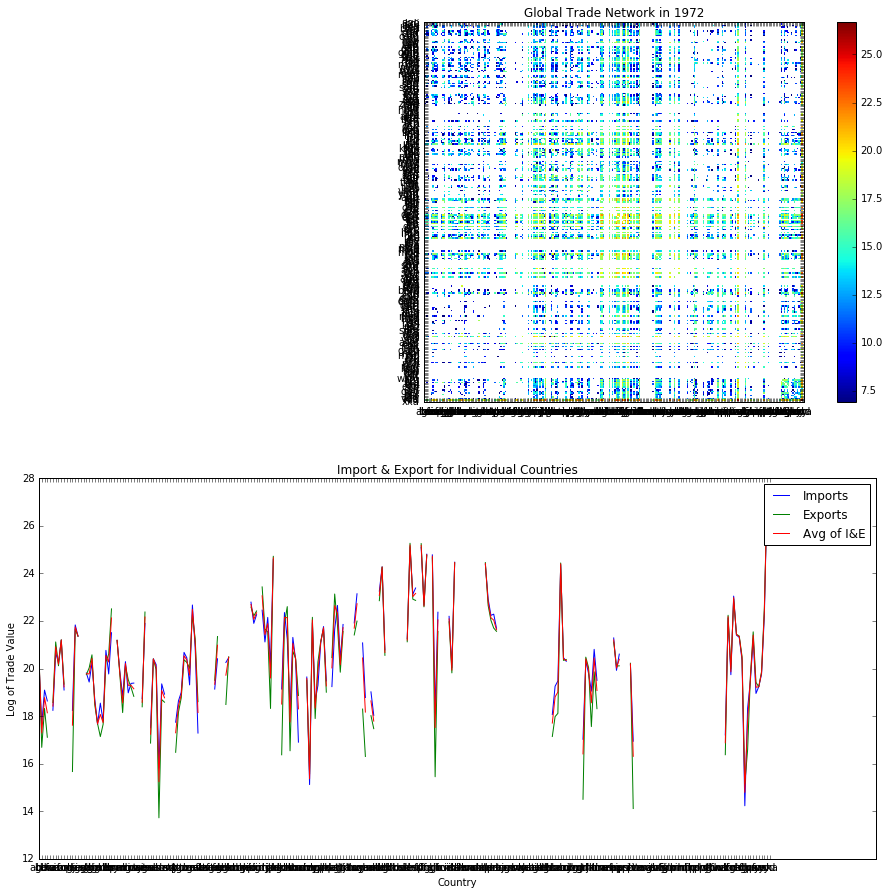

In [7]:
# (6). Plot adjacency matrix and total imports / exports from each country.

if True:
	%matplotlib inline
	plt.figure(figsize=(15,15))

	plt.subplot(2,1,1)
	plt.imshow( np.log(trade_ntwrkA[0:a,0:a]), interpolation='none' )
	plt.title("Global Trade Network in " + str(years[y]))
	plt.colorbar(fraction=0.046, pad=0.04)
	plt.xticks( range(0,a), countries.id_3char[0:a] )
	plt.yticks( range(0,a), countries.id_3char[0:a] )
    
	plt.subplot(2,1,2)
	imprt = plt.plot( np.log(tradeCountry_import[0:a]))#, label="import" )
	exprt = plt.plot( np.log(tradeCountry_export[0:a]))#, label="export" )
	meanIE = plt.plot( np.log( np.mean([tradeCountry_import[0:a],tradeCountry_export[0:a]],axis=0) ))
	plt.title("Import & Export for Individual Countries")
	plt.ylabel("Log of Trade Value")
	plt.xlabel("Country")
	plt.xticks( range(0,a), countries.id_3char[0:a] )
	plt.legend(["Imports","Exports","Avg of I&E"])

In [17]:
np.sum(trade_ntwrkA[0,0:261])

347986000.0

In [ ]:
# (7). Construct directed network Graph object that NetworkX can analyze from the Adjacency matrix loaded from an .npz file

# Set up node position to plot them with relative geographic location preserved.
if True:
	import geopy # this library package allows us to look up latitude and longitude based on a country name.
	from geopy.geocoders import Nominatim

	geolocator = Nominatim()
	trade_ntwrkG = nx.DiGraph() # create the weighted directed graph.

	for o in range(0, a): #num_countries):
		try:
			location = geolocator.geocode(countries.name[o])
			#print([str(o) + ' : ' + countries.name[o]])
			xx = location.longitude
			yy = location.latitude
		except:
			xx = 0
			yy = 0
          
		trade_ntwrkG.add_node(o, pos=(xx,yy), label=countries.id_3char[o])
        
    # set total imports and total exports as node attributes
	nx.set_node_attributes(trade_ntwrkG,'imports_tot',tradeCountry_import[0:a])
	nx.set_node_attributes(trade_ntwrkG,'exports_tot',tradeCountry_export[0:a])
    
        
# Set up weighted edges for World Trade Network Graph.
if True:
	years = range(1962,2014)
	#trade_ntwrkG = nx.DiGraph() # create the weighted directed graph.
    
	# a = 263
	# num_countries = np.size(countries,0)
	nWidth = np.empty(0) # weight of edges in the graph object for nice visualization

	for y in range(9,10): #, len(years)):
        
		for o in range(0, a): # num_countries):
			#print([ str(o) + " : " + countries.id_3char[o] ])

			for d in range(0, a): #num_countries):
				if trade_ntwrkA[o,d]>0:                 
					trade_ntwrkG.add_edge( o, d, weight=trade_ntwrkA[o,d] ) # create the weighted directed graph.
					nWidth = np.append(nWidth, trade_ntwrkA[o,d])

                    
        # save the network as a pickle to be used to compute modularity later.
		nx.write_gpickle( trade_ntwrkG, str( dirPre + 'ntwrkX_pickle_files/adjacency/' + str(years[y]) + '_trade_networkX.gpickle' ) )



In [ ]:
# (8). Plot graph in networkX

if True:
	# (6). Plot graph in networkX
	%matplotlib inline
	fig = plt.figure(figsize=(25,15))

	position = nx.get_node_attributes(trade_ntwrkG,'pos')
    


	nSize = np.log( tradeCountry_export[0:a] )
	nSize = 3000*(nSize/np.max(nSize))

	nWidthB = np.log(nWidth)
	nWidthB = nWidthB-np.min(nWidthB)+1 # subtract off min value and
	#nWidthB = nWidthB/np.max(nWidthB)   # take log of normalized width of edges


	nx.draw_networkx_edges(trade_ntwrkG, pos=position, arrows=False, font_weight='bold', alpha=0.5, width=nWidthB,
							edge_color=nWidthB, edge_vmin=np.min(nWidthB), edge_vmax=np.max(nWidthB), edge_cmap=plt.cm.Greys)
        
	nx.draw_networkx_nodes(trade_ntwrkG, pos=position, node_size=nSize, cmap=plt.cm.Dark2, with_labels=True, 
							font_weight='bold', node_color=node_colors_by_continent)    
    
	nx.draw_networkx_labels(trade_ntwrkG, pos=position, labels=countries.id_3char, font_size=16)
    
	#plt.colorbar()
	plt.xlim(-180, +180)
	plt.ylim(-90,+90)
	plt.grid(linewidth=2)
	plt.ylabel('Latitude', fontsize=20)
	plt.xlabel('Longitude', fontsize=20)
	plt.title( str( 'Trade Map : ' + str(years[y]) ), fontsize=20 ) 
	plt.xticks(fontsize=20)
	plt.yticks(fontsize=20)
	#plt.legend()
    
    # save the figure
	fig.savefig(str( dirPre + 'out_figures/trade_maps/' + str(years[y]) + '_trade_map.png' ))
    


In [ ]:
print(np.min(nWidthB))
print(np.max(nWidthB))